In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import shap
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_parquet('../data/processed/us_accidents_polars.parquet')
df

,Severity,Start_Time,State,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,distance_to_airport(mi)
0,3,2016-02-08 05:46:00,OH,36.9,91.0,29.68,10.0,Calm,8.0,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,2.752093
1,2,2016-02-08 06:07:59,OH,37.9,100.0,29.65,10.0,Calm,8.1,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day,5.800391
2,2,2016-02-08 06:49:27,OH,36.0,100.0,29.67,10.0,SW,3.5,0.00,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day,9.577639
3,3,2016-02-08 07:23:34,OH,35.1,96.0,29.64,9.0,SW,4.6,0.00,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day,10.702810
4,2,2016-02-08 07:39:07,OH,36.0,89.0,29.65,6.0,SW,3.5,0.00,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day,3.308864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7705754,2,2019-08-23 18:03:25,CA,86.0,40.0,28.92,10.0,W,13.0,0.00,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,5.130412
7705755,2,2019-08-23 19:11:30,CA,70.0,73.0,29.39,10.0,SW,6.0,0.00,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,3.397634
7705756,2,2019-08-23 19:00:21,CA,73.0,64.0,29.74,10.0,SSW,10.0,0.00,Partly Cloudy,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day,6.984253
7705757,2,2019-08-23 19:00:21,CA,71.0,81.0,29.62,10.0,SW,8.0,0.00,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,3.184000


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7705759 entries, 0 to 7705758
Data columns (total 29 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Severity                 int64  
 1   Start_Time               object 
 2   State                    object 
 3   Temperature(F)           float64
 4   Humidity(%)              float64
 5   Pressure(in)             float64
 6   Visibility(mi)           float64
 7   Wind_Direction           object 
 8   Wind_Speed(mph)          float64
 9   Precipitation(in)        float64
 10  Weather_Condition        object 
 11  Amenity                  bool   
 12  Bump                     bool   
 13  Crossing                 bool   
 14  Give_Way                 bool   
 15  Junction                 bool   
 16  No_Exit                  bool   
 17  Railway                  bool   
 18  Roundabout               bool   
 19  Station                  bool   
 20  Stop                     bool   
 21  Traffic_

In [6]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='mixed')

df['start_month'] = df['Start_Time'].dt.month
df['start_year'] = df['Start_Time'].dt.year
df['start_hour'] = df['Start_Time'].dt.hour
df['start_day'] = df['Start_Time'].dt.day

In [7]:
df.drop(columns=['Start_Time'], inplace=True, axis=1, errors='ignore')

In [8]:
for col in df.select_dtypes(include=['object']).columns:
    print(f"Column: {col}, Unique Values: {df[col].nunique()}")

Column: State, Unique Values: 49
Column: Wind_Direction, Unique Values: 24
Column: Weather_Condition, Unique Values: 144
Column: Sunrise_Sunset, Unique Values: 2
Column: Civil_Twilight, Unique Values: 2
Column: Nautical_Twilight, Unique Values: 2
Column: Astronomical_Twilight, Unique Values: 2


In [9]:
df['Wind_Direction'].unique()

array(['Calm', 'SW', 'SSW', 'WSW', 'WNW', 'NW', 'West', 'NNW', 'NNE',
       'South', 'North', 'Variable', 'SE', 'SSE', 'ESE', 'East', 'NE',
       'ENE', 'E', 'W', None, 'S', 'VAR', 'CALM', 'N'], dtype=object)

In [10]:
df['Weather_Condition'].unique()

array(['Light Rain', 'Overcast', 'Mostly Cloudy', 'Rain', 'Light Snow',
       'Haze', 'Scattered Clouds', 'Partly Cloudy', 'Clear', 'Snow',
       'Light Freezing Drizzle', 'Light Drizzle', 'Fog', 'Shallow Fog',
       'Heavy Rain', 'Light Freezing Rain', 'Cloudy', 'Drizzle', None,
       'Light Rain Showers', 'Mist', 'Smoke', 'Patches of Fog',
       'Light Freezing Fog', 'Light Haze', 'Light Thunderstorms and Rain',
       'Thunderstorms and Rain', 'Fair', 'Volcanic Ash', 'Blowing Sand',
       'Blowing Dust / Windy', 'Widespread Dust', 'Fair / Windy',
       'Rain Showers', 'Mostly Cloudy / Windy', 'Light Rain / Windy',
       'Hail', 'Heavy Drizzle', 'Showers in the Vicinity', 'Thunderstorm',
       'Light Rain Shower', 'Light Rain with Thunder',
       'Partly Cloudy / Windy', 'Thunder in the Vicinity', 'T-Storm',
       'Heavy Thunderstorms and Rain', 'Thunder', 'Heavy T-Storm',
       'Funnel Cloud', 'Heavy T-Storm / Windy', 'Blowing Snow',
       'Light Thunderstorms and Snow'

In [11]:
df['Weather_Condition'].value_counts()

Weather_Condition
Fair                         2560802
Mostly Cloudy                1016195
Cloudy                        817082
Clear                         808743
Partly Cloudy                 698972
                              ...   
Heavy Sleet / Windy                1
Sand / Windy                       1
Heavy Rain Shower / Windy          1
Blowing Snow Nearby                1
Drifting Snow                      1
Name: count, Length: 144, dtype: int64

In [12]:
dict(df['Weather_Condition'].value_counts())

{'Fair': np.int64(2560802),
 'Mostly Cloudy': np.int64(1016195),
 'Cloudy': np.int64(817082),
 'Clear': np.int64(808743),
 'Partly Cloudy': np.int64(698972),
 'Overcast': np.int64(382866),
 'Light Rain': np.int64(352957),
 'Scattered Clouds': np.int64(204829),
 'Light Snow': np.int64(128680),
 'Fog': np.int64(99238),
 'Rain': np.int64(84331),
 'Haze': np.int64(76223),
 'Fair / Windy': np.int64(35671),
 'Heavy Rain': np.int64(32309),
 'Light Drizzle': np.int64(22684),
 'Thunder in the Vicinity': np.int64(17611),
 'Cloudy / Windy': np.int64(17035),
 'T-Storm': np.int64(16810),
 'Mostly Cloudy / Windy': np.int64(16508),
 'Snow': np.int64(15537),
 'Thunder': np.int64(14202),
 'Light Rain with Thunder': np.int64(13597),
 'Smoke': np.int64(12668),
 'Wintry Mix': np.int64(11703),
 'Partly Cloudy / Windy': np.int64(10241),
 'Heavy T-Storm': np.int64(9671),
 'Light Rain / Windy': np.int64(7946),
 'Light Snow / Windy': np.int64(6826),
 'Heavy Snow': np.int64(5003),
 'Light Thunderstorms and Rain

Since there are about 144 categories, grouping them into more manageable chunk is useful to avoid high cardinality.

In [13]:
def group_weather_conditions(condition):
    """
    Groups weather conditions into broader categories.
    """
    condition = str(condition).lower()
    if 't-storm' in condition or 'thunder' in condition:
        return 'Thunderstorm'
    elif 'snow' in condition or 'sleet' in condition or 'ice' in condition or 'wintry' in condition or 'freezing' in condition or 'hail' in condition:
        return 'Snow/Ice'
    elif 'rain' in condition or 'drizzle' in condition or 'shower' in condition:
        return 'Rain'
    elif 'cloudy' in condition or 'overcast' in condition:
        return 'Cloudy'
    elif 'scattered clouds' in condition or 'partly cloudy' in condition or 'mostly cloudy' in condition:
        return 'Partly Cloudy'
    elif 'fog' in condition or 'mist' in condition or 'haze' in condition:
        return 'Fog/Mist/Haze'
    elif 'clear' in condition or 'fair' in condition:
        return 'Clear/Fair'
    elif 'smoke' in condition or 'dust' in condition or 'sand' in condition or 'ash' in condition:
        return 'Smoke/Dust/Sand'
    elif 'squalls' in condition or 'tornado' in condition or 'funnel' in condition:
        return 'Severe'
    else:
        return 'Other'

In [14]:
df['Weather_Group'] = df['Weather_Condition'].apply(group_weather_conditions)

In [15]:
df['Weather_Group'].value_counts()

Weather_Group
Clear/Fair         3405216
Cloudy             2958899
Rain                512097
Partly Cloudy       204829
Fog/Mist/Haze       188634
Snow/Ice            179749
Other               154076
Thunderstorm         88603
Smoke/Dust/Sand      13533
Severe                 123
Name: count, dtype: int64

In [16]:
df[df['Weather_Group'] == 'Other']['Weather_Condition'].value_counts()

Weather_Condition
N/A Precipitation    3252
Name: count, dtype: int64

In [17]:
df.drop(columns=(['Weather_Condition']), inplace=True, axis=1, errors='ignore')

In [18]:
df

,Severity,State,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,distance_to_airport(mi),start_month,start_year,start_hour,start_day,Weather_Group
0,3,OH,36.9,91.0,29.68,10.0,Calm,8.0,0.02,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,2.752093,2,2016,5,8,Rain
1,2,OH,37.9,100.0,29.65,10.0,Calm,8.1,0.00,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day,5.800391,2,2016,6,8,Rain
2,2,OH,36.0,100.0,29.67,10.0,SW,3.5,0.00,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day,9.577639,2,2016,6,8,Cloudy
3,3,OH,35.1,96.0,29.64,9.0,SW,4.6,0.00,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day,10.702810,2,2016,7,8,Cloudy
4,2,OH,36.0,89.0,29.65,6.0,SW,3.5,0.00,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day,3.308864,2,2016,7,8,Cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7705754,2,CA,86.0,40.0,28.92,10.0,W,13.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,5.130412,8,2019,18,23,Clear/Fair
7705755,2,CA,70.0,73.0,29.39,10.0,SW,6.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,3.397634,8,2019,19,23,Clear/Fair
7705756,2,CA,73.0,64.0,29.74,10.0,SSW,10.0,0.00,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day,6.984253,8,2019,19,23,Cloudy
7705757,2,CA,71.0,81.0,29.62,10.0,SW,8.0,0.00,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,3.184000,8,2019,19,23,Clear/Fair


In [19]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7705759 entries, 0 to 7705758
Data columns (total 32 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   Severity                 int64   
 1   State                    category
 2   Temperature(F)           float64 
 3   Humidity(%)              float64 
 4   Pressure(in)             float64 
 5   Visibility(mi)           float64 
 6   Wind_Direction           category
 7   Wind_Speed(mph)          float64 
 8   Precipitation(in)        float64 
 9   Amenity                  bool    
 10  Bump                     bool    
 11  Crossing                 bool    
 12  Give_Way                 bool    
 13  Junction                 bool    
 14  No_Exit                  bool    
 15  Railway                  bool    
 16  Roundabout               bool    
 17  Station                  bool    
 18  Stop                     bool    
 19  Traffic_Calming          bool    
 20  Traffic_Signal          

In [21]:
df[['start_month', 'start_year', 'start_hour', 'start_day']] = df[['start_month', 'start_year', 'start_hour', 'start_day']].astype('category')

In [22]:
for col in df.select_dtypes(include=['category']).columns:
    print(f"Column: {col}, Categories: {df[col].cat.categories}, Num Categories: {len(df[col].cat.categories)}")

Column: State, Categories: Index(['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'IA', 'ID',
       'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS',
       'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR',
       'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV',
       'WY'],
      dtype='object'), Num Categories: 49
Column: Wind_Direction, Categories: Index(['CALM', 'Calm', 'E', 'ENE', 'ESE', 'East', 'N', 'NE', 'NNE', 'NNW',
       'NW', 'North', 'S', 'SE', 'SSE', 'SSW', 'SW', 'South', 'VAR',
       'Variable', 'W', 'WNW', 'WSW', 'West'],
      dtype='object'), Num Categories: 24
Column: Sunrise_Sunset, Categories: Index(['Day', 'Night'], dtype='object'), Num Categories: 2
Column: Civil_Twilight, Categories: Index(['Day', 'Night'], dtype='object'), Num Categories: 2
Column: Nautical_Twilight, Categories: Index(['Day', 'Night'], dtype='object'), Num Categories: 2
Column: Astronomical_Twilight, Categories: I

In [23]:
df[df.isna().any(axis=1)]

,Severity,State,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,distance_to_airport(mi),start_month,start_year,start_hour,start_day,Weather_Group
601,3,OH,44.6,69.0,29.36,10.0,NaN,10.4,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,18.624366,3,2016,7,11,Other
1957,2,CA,57.0,77.0,29.95,10.0,NaN,6.0,0.0,False,False,True,False,False,False,False,False,False,False,False,True,False,Night,Night,Night,Night,16.795367,7,2016,3,3,Other
1968,2,CA,57.0,77.0,29.95,10.0,NaN,6.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,10.396041,7,2016,8,3,Other
1973,2,CA,57.0,77.0,29.95,10.0,NaN,6.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,10.421936,7,2016,11,3,Other
1978,2,CA,57.0,77.0,29.95,10.0,NaN,6.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,9.432830,7,2016,13,3,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7705628,2,OR,70.0,61.0,26.07,10.0,CALM,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,NaN,8,2019,12,23,Clear/Fair
7705639,2,OR,70.0,60.0,29.92,10.0,WNW,5.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,NaN,8,2019,12,23,Clear/Fair
7705697,2,CA,76.0,56.0,29.72,10.0,NaN,7.0,0.0,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day,10.856916,8,2019,10,23,Other
7705717,4,CA,90.0,17.0,24.91,10.0,VAR,7.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,NaN,8,2019,17,23,Clear/Fair


In [24]:
print(f"The class % of values in the target vaiable Severity is:\n {np.round(df['Severity'].value_counts(normalize=True)*100, 2)}%")

The class % of values in the target vaiable Severity is:
 Severity
2    79.66
3    16.82
4     2.64
1     0.87
Name: proportion, dtype: float64%


## ML Model Preparation

### Scikit-Learn Models

In [25]:
import os

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
# from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier # KNN algorithm
from sklearn.naive_bayes import CategoricalNB

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Severity']), df['Severity'], test_size=0.2, random_state=42, stratify=df['Severity'])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6164607, 31), (1541152, 31), (6164607,), (1541152,))

In [27]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6164607 entries, 6584278 to 1567892
Data columns (total 31 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   State                    category
 1   Temperature(F)           float64 
 2   Humidity(%)              float64 
 3   Pressure(in)             float64 
 4   Visibility(mi)           float64 
 5   Wind_Direction           category
 6   Wind_Speed(mph)          float64 
 7   Precipitation(in)        float64 
 8   Amenity                  bool    
 9   Bump                     bool    
 10  Crossing                 bool    
 11  Give_Way                 bool    
 12  Junction                 bool    
 13  No_Exit                  bool    
 14  Railway                  bool    
 15  Roundabout               bool    
 16  Station                  bool    
 17  Stop                     bool    
 18  Traffic_Calming          bool    
 19  Traffic_Signal           bool    
 20  Turning_Loop           

First experimenting with category encoding for tree based models, using the data types as category for
* XGBoost, CatBoost, LightGBM

For Linear Models or Neural Networds
Mean target encoding will be used

In [28]:
cat_cols = X_train.select_dtypes(include=['category']).columns.tolist()
bool_cols = X_train.select_dtypes(include=['bool']).columns.tolist()
num_cols = X_train.select_dtypes(include=['int', 'float']).columns.tolist()

time_cat_cols = ['start_month', 'start_year', 'start_hour', 'start_day']


other_cols = X_train.select_dtypes(exclude=['category', 'bool', 'int', 'float']).columns.tolist()

print("Categorical Columns:", cat_cols)
print("Boolean Columns:", bool_cols)
print("Numerical Columns:", num_cols)

Categorical Columns: ['State', 'Wind_Direction', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'start_month', 'start_year', 'start_hour', 'start_day', 'Weather_Group']
Boolean Columns: ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']
Numerical Columns: ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'distance_to_airport(mi)']


In [29]:
numerical_pipeline = Pipeline(
    steps=[
        ('imputation_mode', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('Scaler', MinMaxScaler())
    ]
)

# Exclude time-based categorical columns from encoding
encode_cat_cols = [col for col in cat_cols if col not in time_cat_cols]

# Categorical pipeline (excluding time-based features from encoding)
categorical_pipeline = ColumnTransformer(
    transformers=[
        ('cat_encoded', Pipeline([
            ('imputation_cat', SimpleImputer(strategy='most_frequent')),
            ('OrdinalEncoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), encode_cat_cols),
        
        # Pass through time-based categorical columns without transformation
        ('cat_passthrough', 'passthrough', time_cat_cols)
    ]
)

In [30]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_pipeline, num_cols),
        ('categorical', categorical_pipeline, cat_cols)
    ],
    remainder='passthrough'
)

In [31]:
x_train_p = preprocessor.fit_transform(X_train)
x_train_p

array([[0.51689189, 0.8989899 , 0.51424186, ..., 0.        , 1.        ,
        0.        ],
       [0.52364865, 0.95959596, 0.50741941, ..., 0.        , 0.        ,
        0.        ],
       [0.49324324, 0.38383838, 0.5179942 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.53378378, 0.35353535, 0.48916937, ..., 0.        , 0.        ,
        0.        ],
       [0.41925676, 1.        , 0.51816476, ..., 0.        , 0.        ,
        0.        ],
       [0.41216216, 0.74747475, 0.50741941, ..., 0.        , 1.        ,
        0.        ]], shape=(6164607, 31))

In [32]:
x_test_p = preprocessor.transform(X_test)
x_test_p

array([[0.58108108, 0.45454545, 0.5065666 , ..., 0.        , 0.        ,
        0.        ],
       [0.53716216, 0.93939394, 0.50059696, ..., 0.        , 0.        ,
        0.        ],
       [0.50675676, 0.34343434, 0.51048951, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.48783784, 0.43434343, 0.51594747, ..., 0.        , 1.        ,
        0.        ],
       [0.48310811, 0.85858586, 0.49070442, ..., 0.        , 0.        ,
        0.        ],
       [0.49324324, 0.56565657, 0.51031895, ..., 0.        , 0.        ,
        0.        ]], shape=(1541152, 31))

In [33]:
pd.DataFrame(x_train_p)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,0.516892,0.898990,0.514242,0.050000,0.011960,0.000000,0.047921,8.0,8.0,1.0,1.0,1.0,1.0,5.0,12.0,2020.0,23.0,27.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.523649,0.959596,0.507419,0.071429,0.013799,0.002742,0.007943,8.0,6.0,0.0,0.0,0.0,0.0,5.0,11.0,2021.0,18.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.493243,0.383838,0.517994,0.071429,0.003220,0.000000,0.081137,35.0,8.0,0.0,0.0,0.0,0.0,0.0,3.0,2019.0,15.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.493243,0.434343,0.510831,0.071429,0.002760,0.000000,0.051223,3.0,16.0,1.0,1.0,1.0,1.0,0.0,4.0,2022.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.614865,0.101010,0.421968,0.071429,0.008280,0.000000,0.035494,30.0,8.0,0.0,0.0,0.0,0.0,0.0,8.0,2021.0,17.0,24.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6164602,0.564189,0.535354,0.513389,0.071429,0.006440,0.000000,0.025478,8.0,4.0,0.0,0.0,0.0,0.0,1.0,12.0,2021.0,14.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6164603,0.540541,0.414141,0.509125,0.071429,0.002760,0.000000,0.022046,29.0,16.0,1.0,1.0,0.0,0.0,0.0,10.0,2021.0,18.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6164604,0.533784,0.353535,0.489169,0.071429,0.005520,0.000000,0.045991,2.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,2022.0,9.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6164605,0.419257,1.000000,0.518165,0.057143,0.008280,0.000000,0.107776,20.0,1.0,1.0,1.0,1.0,1.0,1.0,11.0,2017.0,20.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
print(f'Train set: {x_train_p.shape}')
print(f'Test set: {x_test_p.shape}')

Train set: (6164607, 31)
Test set: (1541152, 31)


## Model Training

In [35]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Check the new classes
print(f"Original labels: {le.classes_}")
print(f"Encoded labels: {np.unique(y_train_encoded)}")

Original labels: [1 2 3 4]
Encoded labels: [0 1 2 3]


In [36]:
y_test_encoded = le.transform(y_test)

### XGBoost

In [37]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train_encoded)
weights = compute_class_weight('balanced', classes=classes, y=y_train_encoded)
weight_dict = dict(zip(classes, weights))

In [38]:
weight_dict

{np.int64(0): np.float64(28.66832378436698),
 np.int64(1): np.float64(0.3138169187882688),
 np.int64(2): np.float64(1.4862410868068348),
 np.int64(3): np.float64(9.459967896975687)}

In [39]:
sample_weights = np.array([weight_dict[y] for y in y_train_encoded])

In [40]:
from sklearn.pipeline import Pipeline

# Full pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42,
        n_jobs=-1
    ))
])

# Fit with sample weights
xgb_pipeline.fit(X_train, y_train_encoded, classifier__sample_weight=sample_weights)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...), ('categorical', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Create stratified k-fold (essential for imbalanced data)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# XGBoost parameter grid
xgb_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__min_child_weight': [1, 3, 5],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__scale_pos_weight': [1, 3, 5]  # For imbalance
}

# Use balanced_accuracy as scoring metric
grid_search = GridSearchCV(
    xgb_pipeline,
    param_grid=xgb_param_grid,
    cv=cv,
    scoring='balanced_accuracy',  # Best for imbalanced data
    n_jobs=-1,
    verbose=2,
    refit=True
)

grid_search.fit(X_train, y_train_encoded, classifier__sample_weight=sample_weights)

print(f"Best params: {grid_search.best_params_}")
print(f"Best CV balanced accuracy: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


In [82]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1)

xgb_model.fit(
    x_train_p,
    y_train_encoded,
    sample_weight=sample_weights
)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [83]:
y_pred_encoded = xgb_model.predict(x_test_p)
y_pred_encoded

array([1, 3, 1, ..., 1, 0, 2], shape=(1541152,))

In [84]:
y_pred = le.inverse_transform(y_pred_encoded)
y_pred

array([2, 4, 2, ..., 2, 1, 3], shape=(1541152,))

In [85]:
cf_matrix = confusion_matrix(y_test_encoded, y_pred_encoded, labels=np.unique(y_test_encoded))
print(cf_matrix)

[[ 12728    263    210    239]
 [ 90325 698540 255887 182995]
 [ 13204  38809 172734  34490]
 [  2720   6349   8849  22810]]


In [86]:
from sklearn.metrics import balanced_accuracy_score


print(f"The Accuracy is: {balanced_accuracy_score(y_test_encoded, y_pred_encoded)}")
print(f"The Precision is: {precision_score(y_test_encoded, y_pred_encoded, average='macro')}")
print(f"The Recall is: {recall_score(y_test_encoded, y_pred_encoded, average='macro')}")
print(f"The F1 Score is: {f1_score(y_test_encoded, y_pred_encoded, average='macro')}")

The Accuracy is: 0.6855896410297617
The Precision is: 0.38385364860058796
The Recall is: 0.6855896410297617
The F1 Score is: 0.38967774916059783


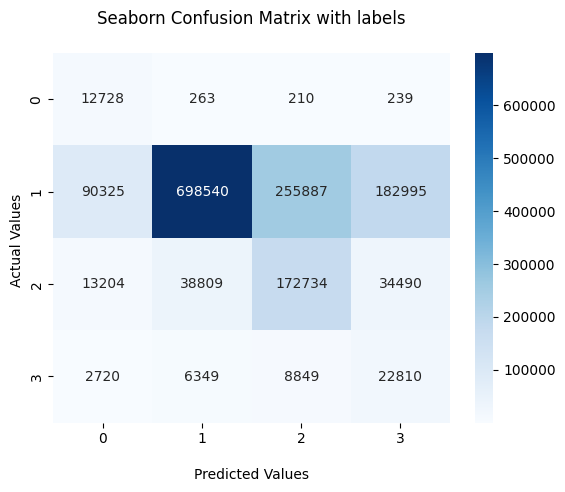

In [87]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

plt.show()

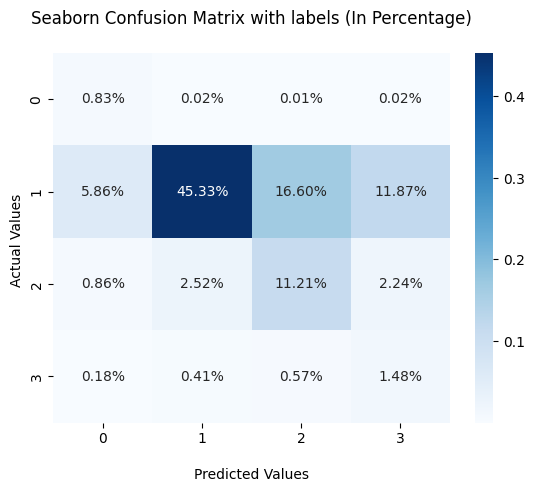

In [88]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels (In Percentage)\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

plt.show()

In [89]:
print(classification_report(
    y_test_encoded,
    y_pred_encoded,
    labels=np.unique(y_test_encoded),
    target_names=le.classes_.astype(str),
    zero_division=0
))

              precision    recall  f1-score   support

           1       0.11      0.95      0.19     13440
           2       0.94      0.57      0.71   1227747
           3       0.39      0.67      0.50    259237
           4       0.09      0.56      0.16     40728

    accuracy                           0.59   1541152
   macro avg       0.38      0.69      0.39   1541152
weighted avg       0.82      0.59      0.65   1541152



In [44]:
print("Classification Report: \n", classification_report(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           1       0.11      0.95      0.19     13440
           2       0.94      0.57      0.71   1227747
           3       0.39      0.67      0.50    259237
           4       0.09      0.56      0.16     40728

    accuracy                           0.59   1541152
   macro avg       0.38      0.69      0.39   1541152
weighted avg       0.82      0.59      0.65   1541152



In [45]:
# Get feature names from the preprocessor
def get_feature_names(preprocessor, input_features):
    """
    Extract feature names from a fitted ColumnTransformer.
    This helps in creating interpretable SHAP plots.
    """
    feature_names = []
    for name, transformer, columns in preprocessor.transformers_:
        if name == 'remainder' and transformer == 'passthrough':
            # Passthrough columns
            feature_names.extend(columns)
        elif hasattr(transformer, 'get_feature_names_out'):
            # For pipelines with encoders
            try:
                names = transformer.get_feature_names_out(columns)
                feature_names.extend(names)
            except:
                feature_names.extend(columns)
        else:
            feature_names.extend(columns)
    return feature_names

In [ ]:
feature_names = list(preprocessor.get_feature_names_out())

X_train_shap = pd.DataFrame(x_train_p, columns=feature_names)
X_test_shap = pd.DataFrame(x_test_p, columns=feature_names)

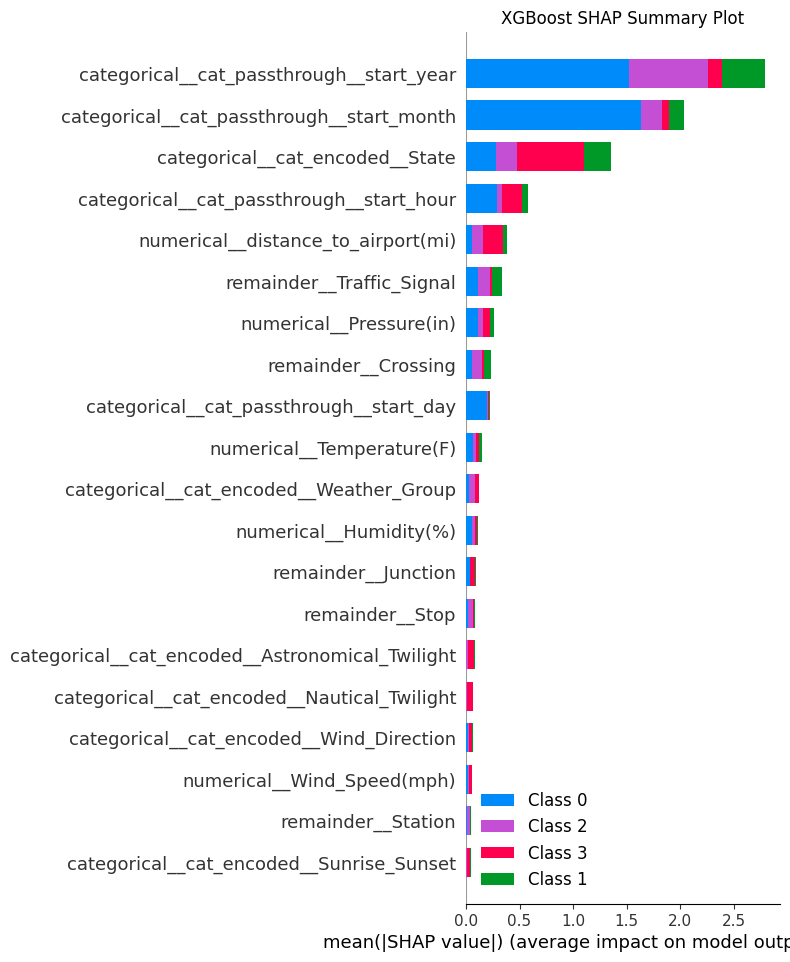

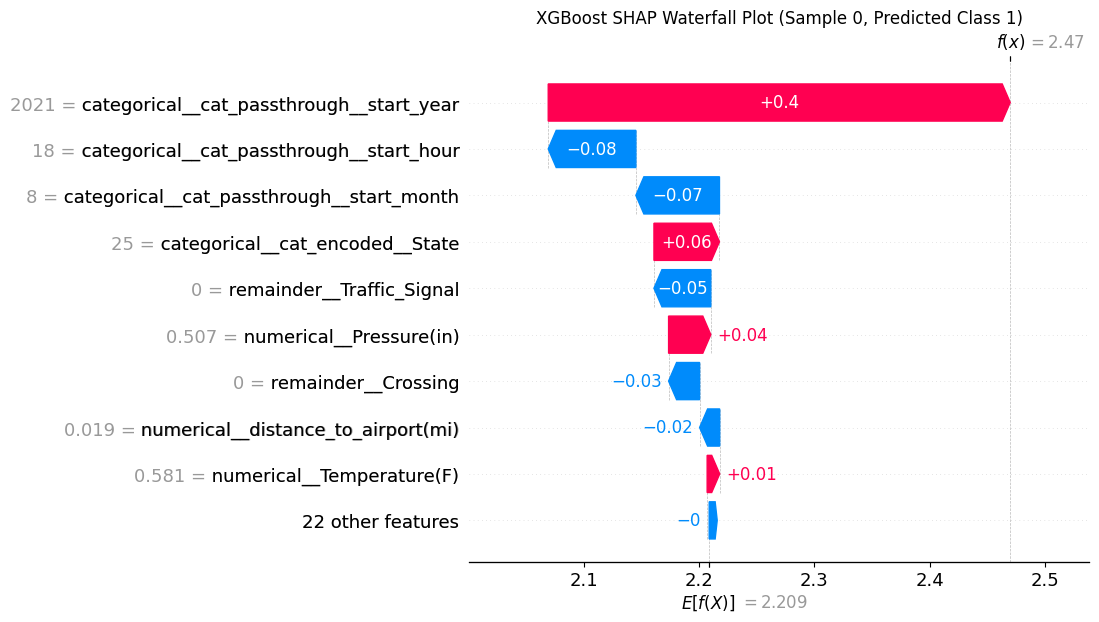

In [ ]:
explainer_xgb = shap.TreeExplainer(xgb_model)

explanation_xgb = explainer_xgb(X_test_shap)

# Summary plot: Shows feature importance and impact distribution
shap.summary_plot(explanation_xgb, show=False)
plt.title("XGBoost SHAP Summary Plot")
plt.show()


sample_idx = 0
pred_class = y_pred_encoded[sample_idx]  
# shap.plots.waterfall(explanation_xgb[sample_idx, pred_class], show=False)  # Slice for sample and class
shap.plots.waterfall(explanation_xgb[sample_idx, :, pred_class], show=False)
plt.title(f"XGBoost SHAP Waterfall Plot (Sample {sample_idx}, Predicted Class {pred_class})")
plt.show()

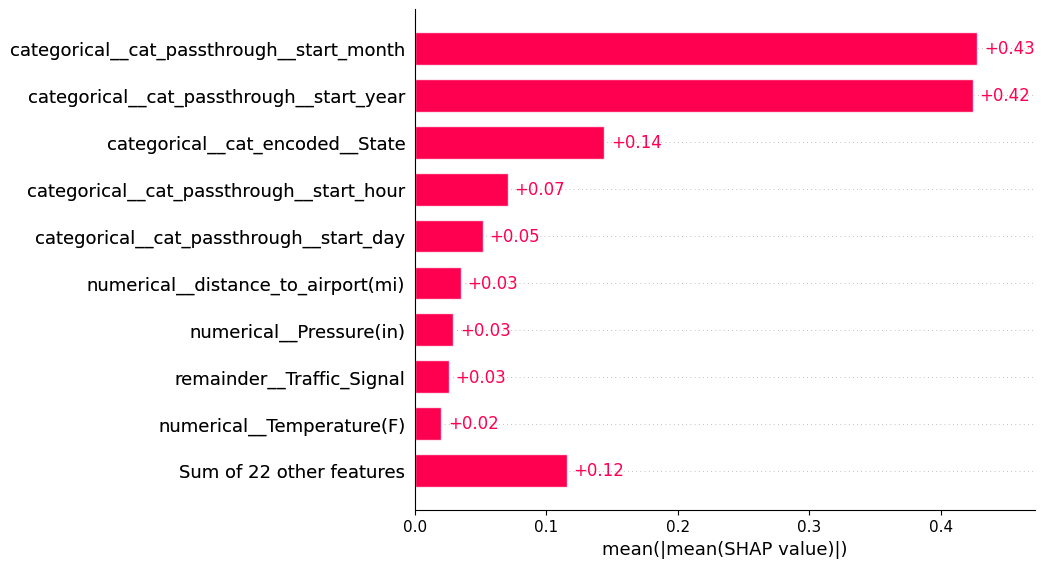

In [54]:
# The 'values' attribute contains the raw SHAP values
# For multi-class, it is usually (N_samples, N_features, N_classes)
# Taking the mean across the class dimension (axis 2) gives global importance
shap.plots.bar(explanation_xgb[:, :, :].mean(2))

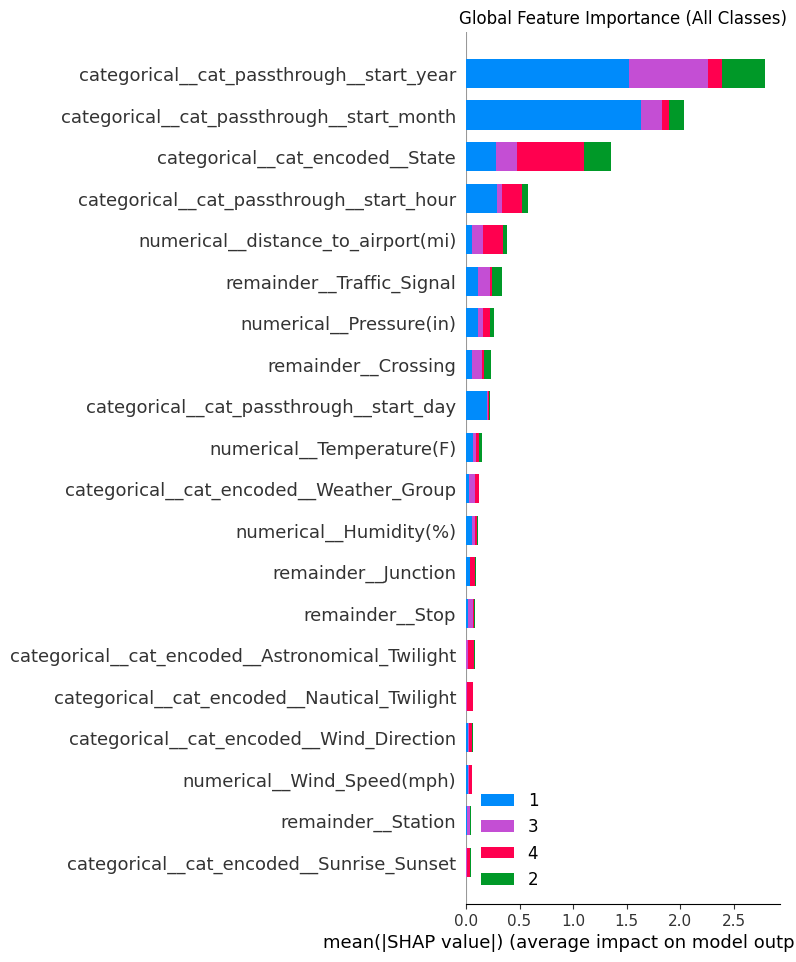

In [ ]:
# Extract the values from the explanation object
# shape will be (samples, features, classes)
shap_values_multiclass = explanation_xgb.values

# Summary plot as a bar chart
# This will show the impact of features across all classes
shap.summary_plot(
    shap_values_multiclass, 
    X_test_shap, 
    plot_type="bar", 
    class_names=le.classes_, # Using LabelEncoder classes for the legend
    show=False
)
plt.title("Global Feature Importance (All Classes)")
plt.show()

In [ ]:
# ...existing code...

# Modified SHAP Explainability for XGBoost, prioritizing high-severity classes (3 and 4, encoded as 2 and 3)
# We'll create separate plots for class 2 (Severity 3) and class 3 (Severity 4)

# Assuming explanation_xgb, X_test_shap, le are from earlier cells
import shap
import matplotlib.pyplot as plt

# Get predictions for the test set
y_pred_encoded = xgb_model.predict(x_test_p)

# Identify samples predicted as class 2 (Severity 3) or class 3 (Severity 4)
class_2_indices = np.where(y_pred_encoded == 2)[0][:100]  # First 10 samples for class 2
class_3_indices = np.where(y_pred_encoded == 3)[0][:100]  # First 10 samples for class 3

# Summary plot for all classes (existing)
shap.summary_plot(explanation_xgb, show=False)
plt.title("XGBoost SHAP Summary Plot (All Classes)")
plt.show()

# Separate summary plots for class 2 (Severity 3)
shap.summary_plot(explanation_xgb[:, :, 2], X_test_shap, show=False)
plt.title("XGBoost SHAP Summary Plot (Class 2: Severity 3)")
plt.show()

# Separate summary plots for class 3 (Severity 4)
shap.summary_plot(explanation_xgb[:, :, 3], X_test_shap, show=False)
plt.title("XGBoost SHAP Summary Plot (Class 3: Severity 4)")
plt.show()

# Waterfall plots for specific samples in high-severity classes
if len(class_2_indices) > 0:
    sample_idx = class_2_indices[0]  # First sample predicted as class 2
    shap.plots.waterfall(explanation_xgb[sample_idx, :, 2], show=False)
    plt.title(f"XGBoost SHAP Waterfall Plot (Sample {sample_idx}, Class 2: Severity 3)")
    plt.show()

if len(class_3_indices) > 0:
    sample_idx = class_3_indices[0]  # First sample predicted as class 3
    shap.plots.waterfall(explanation_xgb[sample_idx, :, 3], show=False)
    plt.title(f"XGBoost SHAP Waterfall Plot (Sample {sample_idx}, Class 3: Severity 4)")
    plt.show()

# Beeswarm plots for class-specific insights
shap.plots.beeswarm(explanation_xgb[:, :, 2], show=False)
plt.title("XGBoost SHAP Beeswarm Plot (Class 2: Severity 3)")
plt.show()

shap.plots.beeswarm(explanation_xgb[:, :, 3], show=False)
plt.title("XGBoost SHAP Beeswarm Plot (Class 3: Severity 4)")
plt.show()

# Bar plot for global importance per class
shap.plots.bar(explanation_xgb[:, :, 2], show=False)
plt.title("XGBoost SHAP Bar Plot (Class 2: Severity 3)")
plt.show()

shap.plots.bar(explanation_xgb[:, :, 3], show=False)
plt.title("XGBoost SHAP Bar Plot (Class 3: Severity 4)")
plt.show()

# Optional: Force plot for a single sample in class 3 (interactive if in Jupyter)
if len(class_3_indices) > 0:
    sample_idx = class_3_indices[0]
    shap.plots.force(explanation_xgb[sample_idx, :, 3], show=False)
    plt.title(f"XGBoost SHAP Force Plot (Sample {sample_idx}, Class 3: Severity 4)")
    plt.show()

# ...existing code...

### LightGBM

In [2]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [37]:
lgb_classifier = LGBMClassifier(
    random_state=42,
    n_jobs=-1
)

lgb_classifier.fit(x_train_p, y_train_encoded)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1245
[LightGBM] [Info] Number of data points in the train set: 6164607, number of used features: 30
[LightGBM] [Info] Start training from score -4.742087
[LightGBM] [Info] Start training from score -0.227349
[LightGBM] [Info] Start training from score -1.782545
[LightGBM] [Info] Start training from score -3.633363


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [38]:
y_pred_encoded = lgb_classifier.predict(x_test_p)
y_pred_encoded

c:\Users\saqui\TensorVault\ZoyaProjectCode\us-accidents-thesis\venv-z\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


array([1, 1, 1, ..., 1, 1, 1], shape=(1541152,))

In [39]:
y_pred = le.inverse_transform(y_pred_encoded)
y_pred

array([2, 2, 2, ..., 2, 2, 2], shape=(1541152,))

In [40]:
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[   3282    9840     316       2]
 [   1652 1190472   35139     484]
 [    167  201932   56734     404]
 [     76   34117    5367    1168]]


In [41]:
print(f"The Accuracy is: {accuracy_score(y_test, y_pred)}")
print(f"The Precision is: {precision_score(y_test, y_pred, average='weighted')}")
print(f"The Recall is: {recall_score(y_test, y_pred, average='weighted')}")

print(f"The F1 Score is: {f1_score(y_test, y_pred, average='weighted')}")

The Accuracy is: 0.8121561014098544
The Precision is: 0.7786160645231038
The Recall is: 0.8121561014098544
The F1 Score is: 0.7699805159481015


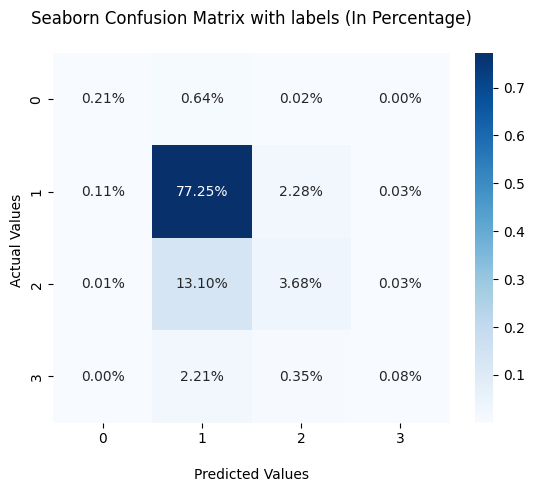

In [42]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels (In Percentage)\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

plt.show()

In [43]:
print("Classification Report: \n", classification_report(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           1       0.63      0.24      0.35     13440
           2       0.83      0.97      0.89   1227747
           3       0.58      0.22      0.32    259237
           4       0.57      0.03      0.05     40728

    accuracy                           0.81   1541152
   macro avg       0.65      0.37      0.40   1541152
weighted avg       0.78      0.81      0.77   1541152



### CatBoost

In [44]:
import catboost
from catboost import CatBoostClassifier

In [45]:
cb_classifier = CatBoostClassifier(
    random_state=42,
    verbose=0
)
cb_classifier.fit(x_train_p, y_train_encoded)

In [46]:
y_pred_encoded = cb_classifier.predict(x_test_p)
y_pred_encoded

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], shape=(1541152, 1))

In [47]:
y_pred = le.inverse_transform(y_pred_encoded)
y_pred

c:\Users\saqui\TensorVault\ZoyaProjectCode\us-accidents-thesis\venv-z\Lib\site-packages\sklearn\preprocessing\_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([2, 2, 2, ..., 2, 2, 2], shape=(1541152,))

In [48]:
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[   2801   10296     343       0]
 [   1061 1184848   41221     617]
 [     93  188764   69881     499]
 [     55   33435    5904    1334]]


In [49]:
print(f"The Accuracy is: {accuracy_score(y_test, y_pred)}")
print(f"The Precision is: {precision_score(y_test, y_pred, average='weighted')}")
print(f"The Recall is: {recall_score(y_test, y_pred, average='weighted')}")

print(f"The F1 Score is: {f1_score(y_test, y_pred, average='weighted')}")

The Accuracy is: 0.8168331222358339
The Precision is: 0.7866137206256244
The Recall is: 0.8168331222358339
The F1 Score is: 0.7805599738922377


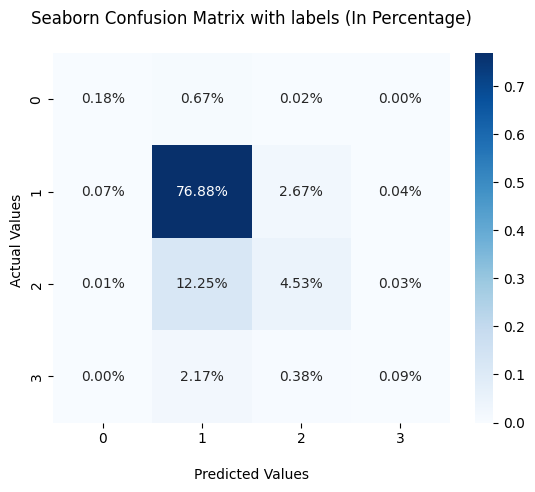

In [50]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels (In Percentage)\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

plt.show()

In [51]:
print("Classification Report: \n", classification_report(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           1       0.70      0.21      0.32     13440
           2       0.84      0.97      0.90   1227747
           3       0.60      0.27      0.37    259237
           4       0.54      0.03      0.06     40728

    accuracy                           0.82   1541152
   macro avg       0.67      0.37      0.41   1541152
weighted avg       0.79      0.82      0.78   1541152



In [1]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost

In [ ]:
mlflow.set_experiment("US_Accidents_Severity_Classification")
